# k-means clustering

In [1]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes, fetch_mldata

## MNIST digits

In [39]:
df_digits = pd.read_csv("data/mnist-10k-sample.csv")
n = 3000
df_subset = df_digits.sample(n=n, replace=False)
images = df_subset.drop('digit', axis=1) # get just pixels
y = df_subset['digit']

In [40]:
k = 10
kmeans = KMeans(k)
kmeans.fit(df_subset.values)
y_pred = kmeans.predict(df_subset)
correct = np.sum(y!=y_pred)
print(f"{correct}/{n}={100*correct/n:.1f}% correct")

2956/3000=98.5% correct


Test in a loop; varies a lot

In [106]:
results = []
for i in range(10):
    n = 1000
    df_subset = df_digits.sample(n=n, replace=False)
    images = df_subset.drop('digit', axis=1) # get just pixels
    y = df_subset['digit']
    k = 10
    kmeans = KMeans(k)
    kmeans.fit(df_subset.values)
    y_pred = kmeans.predict(df_subset)
    correct = np.sum(y!=y_pred)
    print(f"{correct}/{n}={100*correct/n:.1f}% correct")
    results.append(correct)
print(f"Avg {np.mean(results)}/{n}={100*correct/n:.1f}% correct, stddev {100*np.std(results)/n:.2f}%")

997/1000=99.7% correct
967/1000=96.7% correct
973/1000=97.3% correct
744/1000=74.4% correct
906/1000=90.6% correct
897/1000=89.7% correct
900/1000=90.0% correct
999/1000=99.9% correct
998/1000=99.8% correct
980/1000=98.0% correct
Avg 936.1/1000=98.0% correct, stddev 7.51%


## Breast cancer data

In [27]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

In [67]:
results = []
for i in range(15):
    kmeans = KMeans(n_clusters=2, init='random')
    kmeans.fit(X)
    y_pred = kmeans.predict(X)
    correct = np.sum(y!=y_pred)
    print(f"{correct}/{len(X)}={100*correct/len(X):.1f}% correct")
    results.append(correct)
print(f"Avg {np.mean(results):.0f}/{len(X)}={100*np.mean(results)/len(X):.1f}% correct, stddev {100*np.std(results)/len(X):.2f}%")    

83/569=14.6% correct
83/569=14.6% correct
83/569=14.6% correct
486/569=85.4% correct
486/569=85.4% correct
83/569=14.6% correct
83/569=14.6% correct
486/569=85.4% correct
83/569=14.6% correct
83/569=14.6% correct
486/569=85.4% correct
486/569=85.4% correct
83/569=14.6% correct
486/569=85.4% correct
83/569=14.6% correct
Avg 244/569=42.9% correct, stddev 34.70%


In [68]:
X.shape

(569, 30)

## Image color vector quantization

From [sklearn[(https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html)

Modified by parrt to load custom image.

Automatically created module for IPython interactive environment
Fitting model on a small sub-sample of the data
done in 0.119s.
Predicting color indices on the full image (k-means)
done in 0.089s.
Predicting color indices on the full image (random)
done in 0.057s.


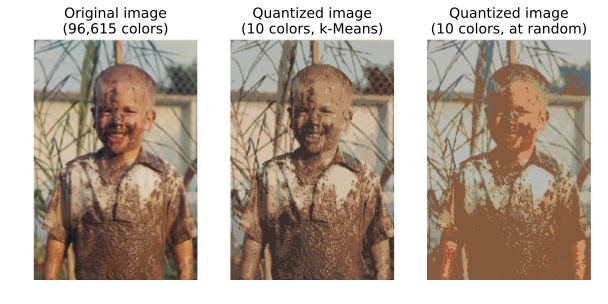

In [89]:
%config InlineBackend.figure_formats = ['svg']

# Authors: Robert Layton <robertlayton@gmail.com>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#
# License: BSD 3 clause

print(__doc__)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from skimage.io import imread
from time import time

n_colors = 10

# Load the Summer Palace photo
parrt = imread("parrt.jpg")

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
parrt = np.array(parrt, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(parrt.shape)
assert d == 3
image_array = np.reshape(parrt, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0)[:2000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print("done in %0.3fs." % (time() - t0))

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print("done in %0.3fs." % (time() - t0))


codebook_random = shuffle(image_array, random_state=0)[:n_colors]
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random,
                                          image_array,
                                          axis=0)
print("done in %0.3fs." % (time() - t0))


def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
fig, axes = plt.subplots(1,3,figsize=(10,10))
axes[0].axis('off')
axes[0].set_title(f'Original image\n(96,615 colors)', fontsize=14)
axes[0].imshow(parrt)

axes[1].axis('off')
axes[1].set_title(f'Quantized image\n({n_colors} colors, k-Means)', fontsize=14)
axes[1].imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

axes[2].axis('off')
axes[2].set_title(f'Quantized image\n({n_colors} colors, at random)', fontsize=14)
axes[2].imshow(recreate_image(codebook_random, labels_random, w, h))

plt.show()
